# Ridge Regression on California Housing Dataset
*This notebook builds ridge regression models for predicting housing prices in California.*

## Import Dependencies

In [1]:
import numpy as np
import scipy
from collections import defaultdict
import peak_engines
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt

## Prepare Dataset

In [2]:
X, y = fetch_california_housing(return_X_y=True)

# Remove some extreme outliers
occ_max = np.percentile(X[:,5], 99)
X[:, 5] = [min(x, occ_max) for x in X[:, 5]]

## Set up a validation simulation

In [3]:
def validate_models(models, n, num_trials):
    result = defaultdict(list)
    for _ in range(num_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n)
        for name, model in models:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            result[name].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    return result

def run_simulation(models, train_sizes, num_trials):
    result = defaultdict(lambda: defaultdict(list))
    for n in train_sizes:
        for name, errors in validate_models(models, n, num_trials).items():
            mean = np.mean(errors)
            stddev = np.std(errors, ddof=1)
            interval = scipy.stats.t.interval(alpha=0.95, df=num_trials-1, scale=stddev/np.sqrt(num_trials))
            result[name]['mean'].append(mean)
            result[name]['error_bar'].append(interval[1])
    return result

## Run validation simulation

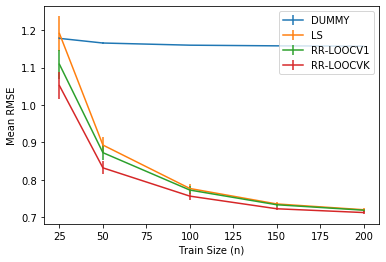

In [4]:
np.random.seed(0)
models = [
    ('DUMMY', DummyRegressor()),
    ('LS', LinearRegression()),
    ('RR-LOOCV1', peak_engines.RidgeRegressionModel(normalize=True)),
        # Use a single regularizer for all regressors set so as to minimize the 
        # leave-one-out cross-validation error on the training dataset
    ('RR-LOOCVK', peak_engines.RidgeRegressionModel(grouping_mode='none', normalize=True))
        # Use a separate regularizer for each regressor set so as to minimize the
        # leave-one-out cross-validation error on the training dataset
]
train_sizes = [25, 50, 100, 150, 200]
num_trials = 500
simulation_results = run_simulation(models, train_sizes, num_trials)

for name, simulation_result in simulation_results.items():
    plt.errorbar(train_sizes, 
                 simulation_result['mean'], 
                 yerr=simulation_result['error_bar'], 
                 label=name)
plt.legend(loc='upper right')
plt.xlabel('Train Size (n)')
plt.ylabel('Mean RMSE')
plt.show()